In [9]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import expanduser
import pickle

In [10]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
RT_LOWER = 1650
RT_UPPER = 2200

#### prepare the MaxQuant results

In [11]:
mq_results_df = pd.read_csv('{}/evidence-P3856.txt'.format(expanduser('~')), sep='\\t', engine='python')

In [12]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# only those identifications for this run
mq_results_df = mq_results_df[mq_results_df['Raw file'] == run_name]
# only MS/MS
mq_results_df = mq_results_df[mq_results_df['Type'] == 'TIMS-MULTI-MSMS']
# remove identifications with large mass error
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 20.0]
# only those in the RT region of interest
mq_results_df = mq_results_df[(mq_results_df['Retention time']*60.0 > RT_LOWER) & (mq_results_df['Retention time']*60.0 < RT_UPPER)]

In [13]:
mq_results_df['Type'].unique()

array(['TIMS-MULTI-MSMS'], dtype=object)

In [14]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [19]:
mq_results_df['Modifications'].value_counts()

Unmodified                               7270
Acetyl (Protein N-term)                   132
Oxidation (M)                              51
2 Oxidation (M)                             3
Acetyl (Protein N-term),Oxidation (M)       3
Name: Modifications, dtype: int64

In [23]:
mq_sequences_l = []
for group_name,group_df in mq_results_df[(mq_results_df['Modifications']=='Unmodified')].groupby(unique_peptide_key, as_index=False):
    mq_sequences_l.append({'sequence':group_name[0], 'charge':group_name[2], 'mass_error_ppm':group_df['Mass error [ppm]'].min()})
unique_identifications_mq_df = pd.DataFrame(mq_sequences_l)

In [24]:
len(unique_identifications_mq_df)

7109

#### compare mass error of peptides found in common 

In [25]:
IDENTIFICATIONS_WITH_CS_FILE = '/home/daryl/P3856-results-cs-true-fmdw-false-2021-04-18-08-57-31/identifications-pasef/exp-P3856-identifications-pasef-recalibrated.pkl'
MAXIMUM_Q_VALUE = 0.01

In [41]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_WITH_CS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_cs_df = d['identifications_df']
# identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

In [42]:
sequences_l = []
for group_name,group_df in identifications_with_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'mass_error_ppm':mass_accuracy_ppm})
sequences_with_cs_df = pd.DataFrame(sequences_l)

In [43]:
combined_df = pd.merge(unique_identifications_mq_df, sequences_with_cs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'], suffixes=['_mq','_ours'])


In [48]:
combined_df.sample(n=5)

,sequence,charge,mass_error_ppm_mq,mass_error_ppm_ours
1898,IMNVIGEPIDER,2,0.175120,0.935928
1262,GEELEIVGHNSTPLK,2,0.357050,0.088589
2415,LNLIVDPNQRPVK,2,-0.044671,-0.344801
2470,LPPLPSLTSQPHQVLASEPIPFSDLQQVSR,3,-2.114700,-3.096152
597,DNALLSAIEESRK,2,-0.945200,-0.531931


In [47]:
len(combined_df)

4457

In [54]:
combined_df.mass_error_ppm_mq.max()

9.5718

In [50]:
combined_df.mass_error_ppm_mq.std(), combined_df.mass_error_ppm_ours.std()

(1.3802092312753167, 4.002593994871528)

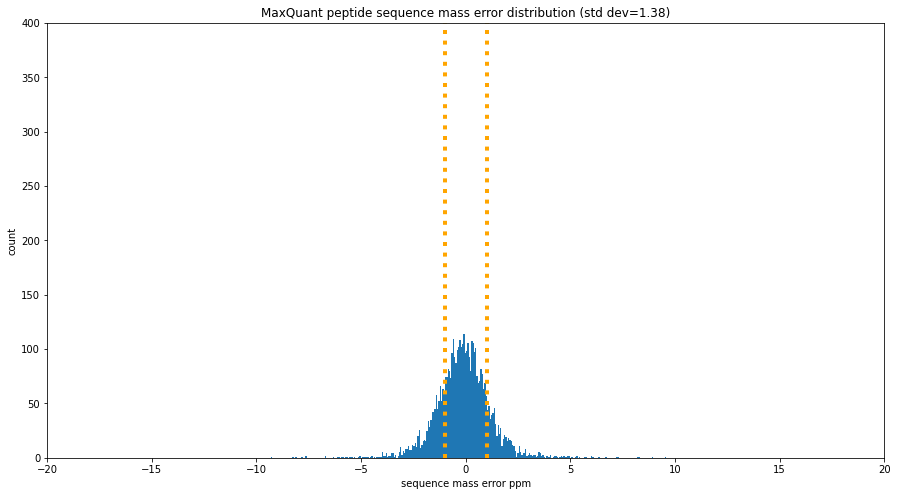

In [58]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('MaxQuant peptide sequence mass error distribution (std dev={})'.format(round(combined_df.mass_error_ppm_mq.std(),2)))

bins = 300
hist, bins, _ = plt.hist(combined_df.mass_error_ppm_mq, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,400))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

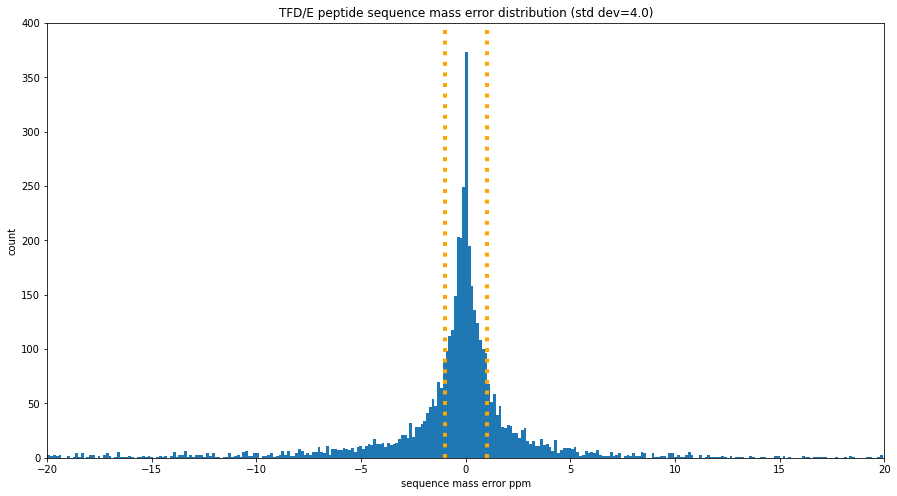

In [59]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('TFD/E peptide sequence mass error distribution (std dev={})'.format(round(combined_df.mass_error_ppm_ours.std(),2)))

bins = 300
hist, bins, _ = plt.hist(combined_df.mass_error_ppm_ours, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,400))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### prepare the MSFragger results

In [22]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSstats-without-MBR.csv'.format(EXPERIMENT_DIR), sep=',')


In [23]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [24]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
212564,sp|P26368|U2AF2_HUMAN,LFIGGLPNYLNDDQVK,2,NaN,NaN,L,YHE114,4,P3856_YHE114_4_Slot1-1_1_5118,83068.330
500722,sp|Q6P2Q9|PRP8_HUMAN,GPGNPVPGPLAPLPDYMSEEK,2,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,195592.890
188000,sp|P21281|VATB2_HUMAN,GPVVLAEDFLDIMGQPINPQC[57.0215]R,3,NaN,NaN,L,YHE211,10,P3856_YHE211_10_Slot1-1_1_5113,28382.742
642703,sp|Q9P258|RCC2_HUMAN,NHTLALTETGSVFAFGENK,2,NaN,NaN,L,YHE114,3,P3856_YHE114_3_Slot1-1_1_5117,68730.630
373177,sp|P63010|AP2B1_HUMAN,LAPPLVTLLSGEPEVQYVALR,3,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,31515.666


In [25]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [26]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])